# Semantic Based-Regularization 

In this notebook, we will how to implement a simple example of SBR in a multiclass context with hierarchical structure. 

### Example: 
We simulate a data set that consists of images of geomtric shapes categorized into two main families: **Polygons** (squares and triangles) and **Curved shapes** (all circles). Each sample is categorized with two labels: one indicating the geomtric family (polygon or curved) and another specifying the exact shape (square, triangle or circle)

We will first implement a baseline CNN model to predict the labels of each image.
Next, we will compare its performance with a CNN enhanced by Semantic-Based Regularization (CNN-SBR), where logical rules are incorporated as a regularization term in the loss function



In [1]:
import torch 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns

from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score


from modular import engine
from modular import extra_functions as ef
from modular import model_builder
import modular.samples_setup as cs

### Lets start by simulating some data 
To simulate the geometric shapes we will use the `draw_circles`, `draw_triangle` and 
`draw_square` functions from the `extra_functions` module in `modular`

Then, we will generate a sample containing all these elements. This sample will have two type of labels: one for the main category (polygons or curved shapes) and another for the subclasses (circles,squares or triangles). 

To achieve this, we define the `generate_hierarchical_sample` function bellow

In [2]:
def generate_hierarchical_sample(n , noise_prop,seed = 999,size = 28, var = 0.15,
                    noise_indx = False):
    
    """Generates hierarchical samples.

     Args:
        n: vector of lenght amount of subclasses, containing the number of images of 
        each subclass to be generated in the following order: circles, ellipses, squares,
        rectangles and equilateral and isosceles.
        noise_prop: proportion of the data with noise
        seed: seed to perform the simulation. Default = 999.
        size: size of the image as number of pixels.
        var: variance for the Gaussian Error. Default = 0.15.
        noise_indx: Boolean indicating wheather the indexes of noisy samples 
        should be return. Default= False.
       
    Returns:
        A Dictionary of Arrays of images and labels simulated.
        In the form (images, sub_labels,main_lables)
        and (images, sub_labels,main_lables, noisy index) if noise_indx =True
    
  """
      
    dataset_circles = []
    dataset_squares = []
    dataset_triangles = []
        
    ntot = sum(n)
    n_cr = n[0]
    n_sq = n[1]
    n_tr = n[2]
                    
    # Create circles
    for _ in range(n_cr):
        radius = np.random.randint(2, size // 2)  #
        image = ef.draw_circle(size, radius)
        dataset_circles.append(image)
                
    # Create squares
    for _ in range(n_sq):
        len_size = np.random.randint(2, size)  
        image = ef.draw_square(size, len_size)
        dataset_squares.append(image)
        
    # Create triangles
    for _ in range(n_tr):
        len_size = np.random.randint(2, size )  
        image = ef.draw_triangle(size, len_size)
        dataset_triangles.append(image)
        
                
    ## Add noise to some of them
    np.random.seed(seed)
     
    # circles      
    noisy_indices_c = np.random.choice(n_cr, int(n_cr * noise_prop), replace=False)
    for i in noisy_indices_c: 
        dataset_circles[i] = ef.add_gaussian_noise(dataset_circles[i],var=var)
        
    # squares
    noisy_indices_s = np.random.choice(n_sq, int(n_sq * noise_prop), replace=False)
    for i in noisy_indices_s:
        dataset_squares[i] = ef.add_gaussian_noise(dataset_squares[i],var=var)
        
    # triangles
    noisy_indices_is = np.random.choice(n_tr, int(n_tr * noise_prop), replace=False)
    for i in noisy_indices_is:
        dataset_triangles[i] = ef.add_gaussian_noise(dataset_triangles[i],var=var)    
        
    # Create sub labels
    circle_labels = np.full(n_cr, 0)
    square_labels = np.full(n_sq, 1)
    traingle_labels = np.full(n_tr, 2)
    
    curved_labels = np.full(n_cr , 0)
    polygon_labels = np.full(n_sq + n_tr, 1)
    
    # # Combine datasets
    all_images = np.concatenate((dataset_circles , dataset_squares,
                                 dataset_triangles))
                                    
    all_sublabels = np.concatenate((circle_labels, square_labels, 
                                    traingle_labels))

    all_mainlabels = np.concatenate((curved_labels,polygon_labels))
     
    # Shuffle the dataset
    indices = np.arange(len(all_images))
    np.random.seed(seed)
    np.random.shuffle(indices)
    all_images = all_images[indices]
    all_sublabels = all_sublabels[indices]
    all_mainlabels = all_mainlabels[indices]
    noisy_indx  = np.concatenate((noisy_indices_c,ntot + noisy_indices_s))
    noisy_indx = np.nonzero(np.isin(indices, noisy_indx))[0]
        
    # recover noisy indices
    if noise_indx:
        noisy_indx  = np.concatenate((noisy_indices_c,ntot + noisy_indices_s))    
        output = {"images": all_images,
                "sublabels": all_sublabels,
                "mainlabels": all_mainlabels,
                "indx_noisy_data": noisy_indx}
    else:
        output = {"images": all_images,
                "sublabels": all_sublabels,
                "mainlabels": all_mainlabels}
    return output

Let's now simulate some data and examine the outputs. We will create a data set with 40 samples per subclass, and with half of the data with Gaussian noise 

In [3]:
seed = 1222
n_samples = [40] * 3

output = generate_hierarchical_sample(n=n_samples, noise_prop = 0.5, seed = 999,
                                      size = 35, var = 0.15,noise_indx = False)

images, sublabels, mainlabels= (output['images'], output['sublabels'],
                                output['mainlabels'])

Let's plot the data

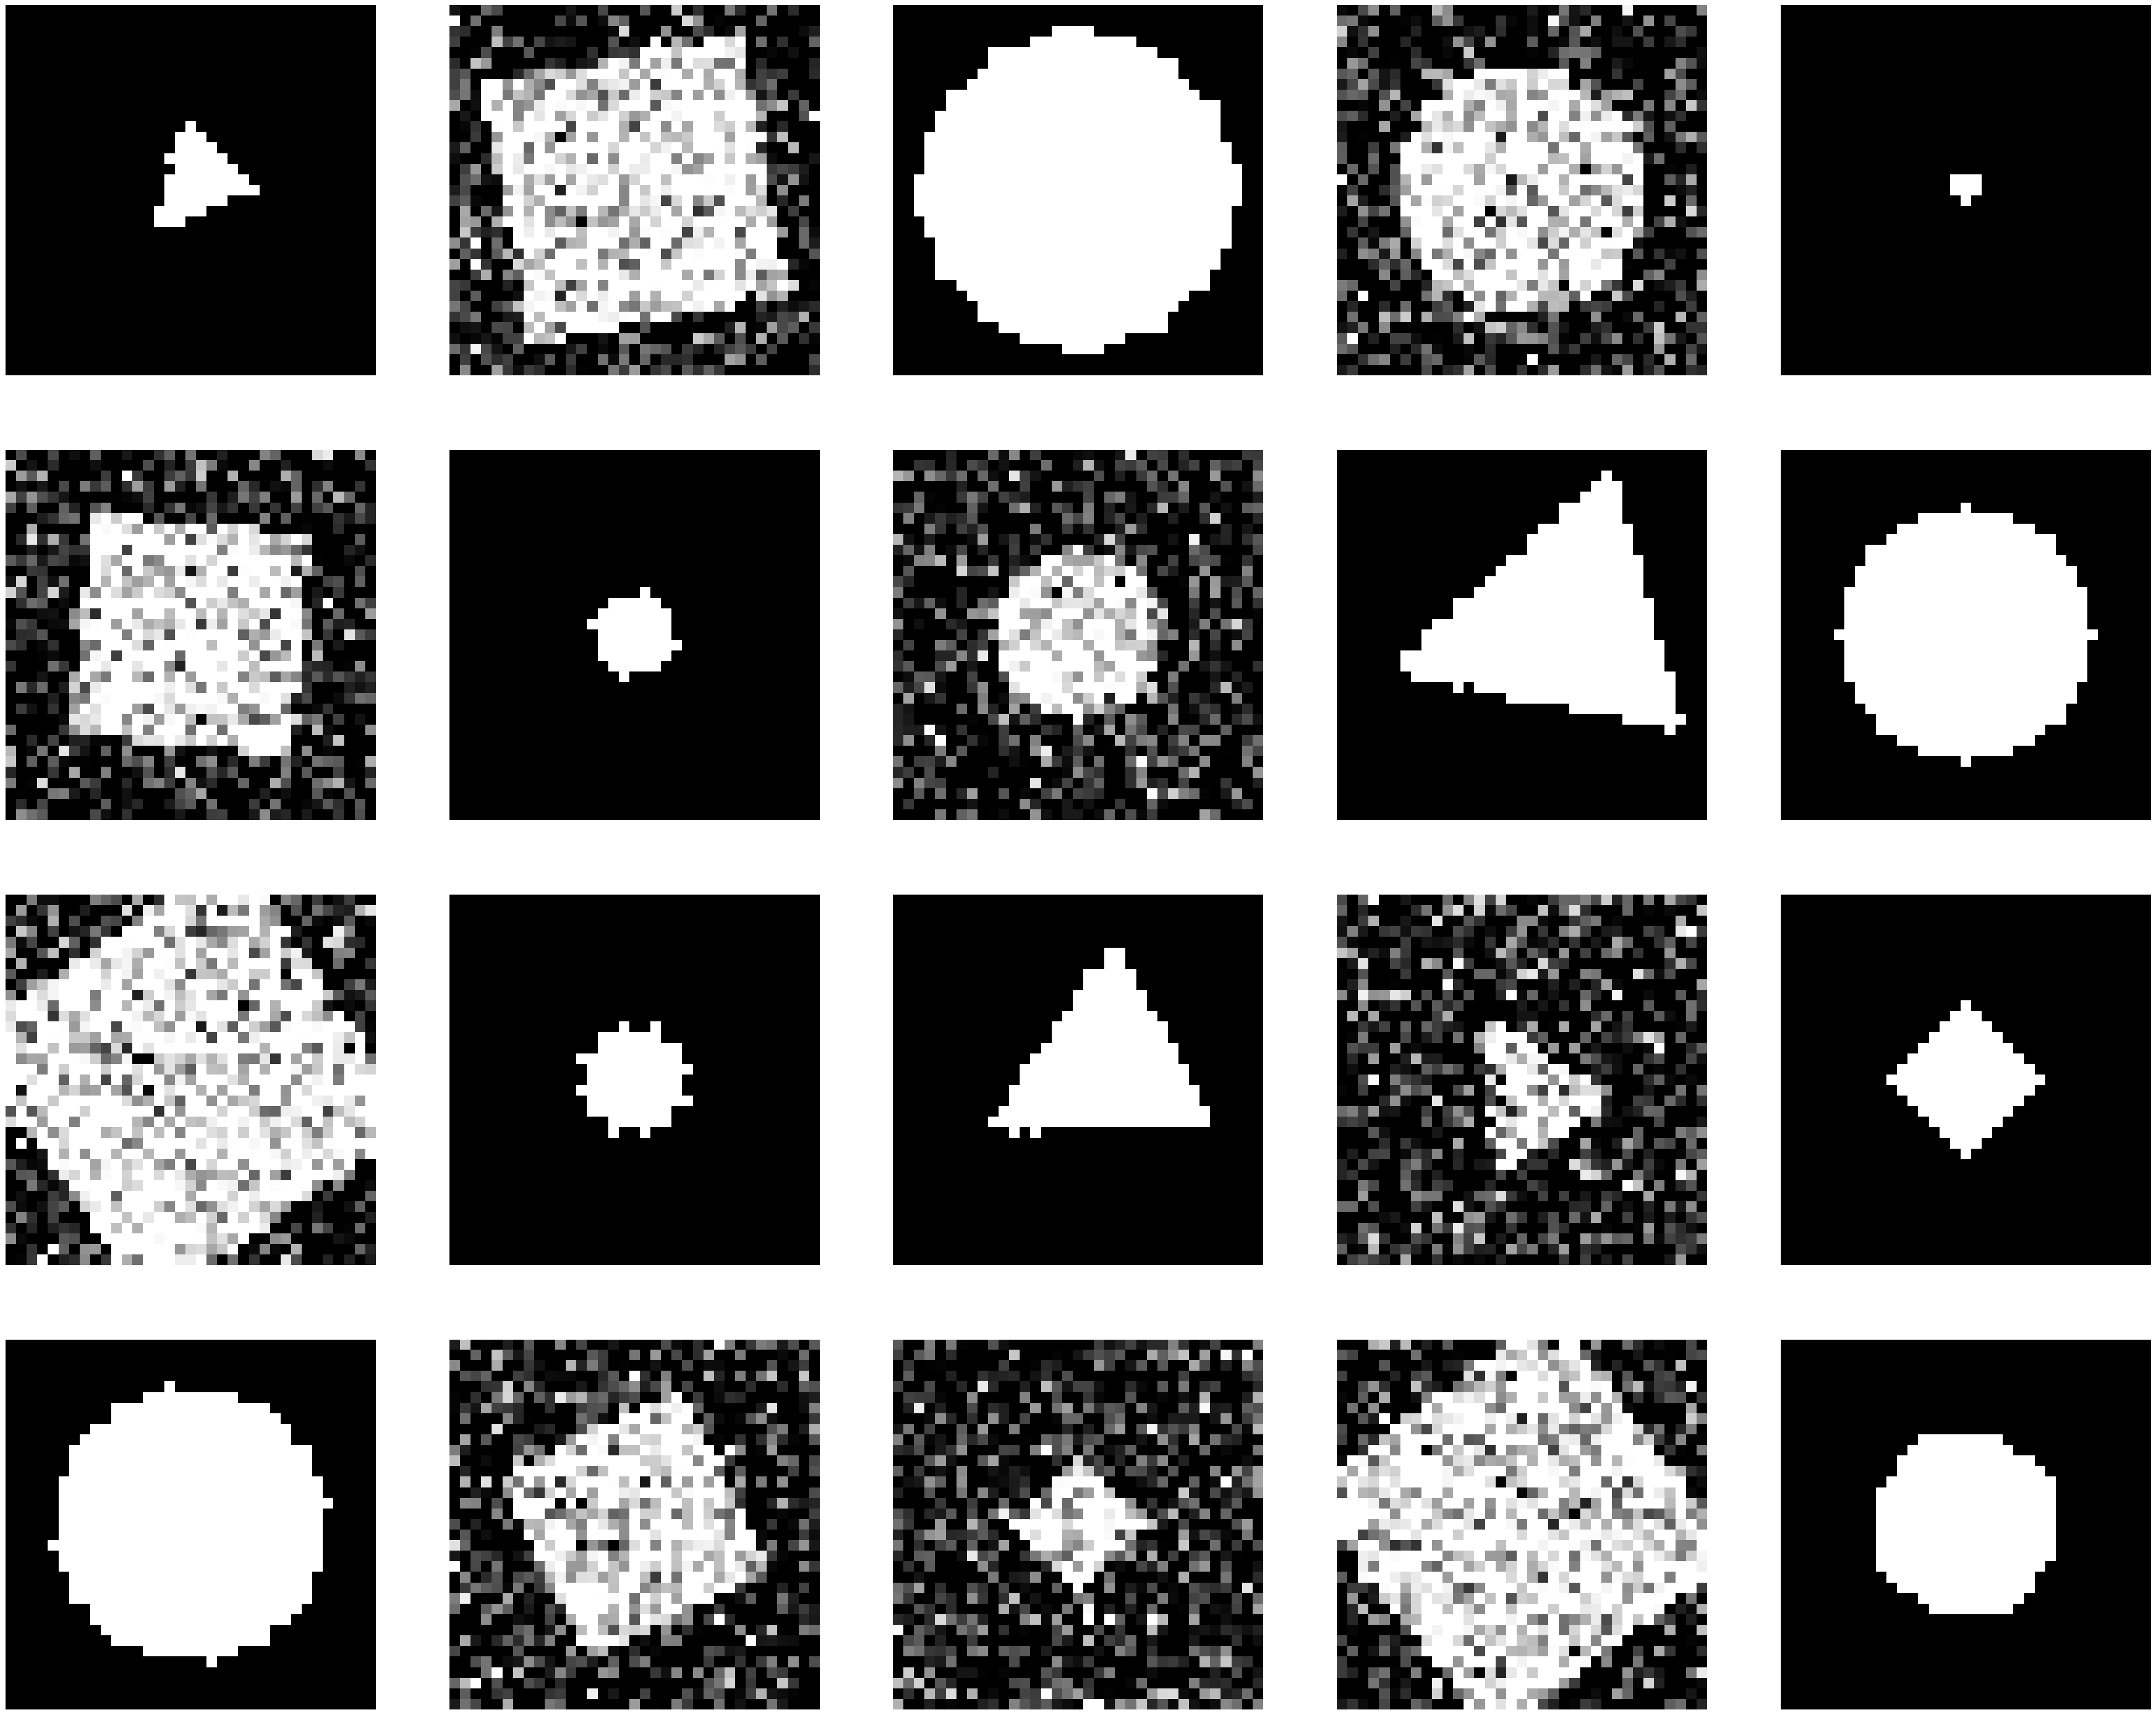

In [4]:
fig, axes = plt.subplots(4, 5, figsize=(50,40))
    
# Flatten the axes array for easier looping
axes = axes.flatten()
    
# Loop through images and axes
for i in range(20):
    axes[i].imshow(images[i], cmap='gray')
    axes[i].axis('off')  



## Create datasets

Perfect!. We finally need to create a dataset containing the training and test set
from our previous sample. To achive this we define the `generate_hierarchical_dataset`
function 

In [5]:
from sklearn.model_selection import train_test_split

def generate_hierarchical_dataset(all_images, all_sublabels, all_mainlabels, 
                                  test_size=0.2,seed = 999):

    """Generate Hierarchical dataset from data sample.

     Args:
        all_images: A array with images generated from `generate_hierarchical_sample`
        all_sublabels: A array of sub labels corresponding to the images,
        generated from`generate_hierarchical_sample`
        all_mainlabels: A array of main labels corresponding to the images,
        generated from`generate_hierarchical_sample`
        test_size: proportion of of the total amount of images to be used for 
        testing. Default = 0.2.
        seed: seed to perform the simulation. Default = 999.

        
    Returns:
        A tuple of TensorDatasets of train and test data sets.
        In the form (train_dataset, test_dataset)
    
  """
    
    X = torch.from_numpy(all_images).type(torch.float)
    Y_main = torch.from_numpy(all_mainlabels).type(torch.long)
    Y_sub = torch.from_numpy(all_sublabels).type(torch.long)

    (
     X_train, X_test, y_main_train, 
     y_main_test, y_sub_train, y_sub_test
     ) = train_test_split(
        X, Y_main,Y_sub, test_size=test_size, random_state=seed
    ) 

    # Add channel at dimension 1 (greyscale)
    X_train = X_train.unsqueeze(1)  
    X_test = X_test.unsqueeze(1)
        
    train_dataset = torch.utils.data.TensorDataset(
        X_train,y_main_train, y_sub_train
        )
    test_dataset = torch.utils.data.TensorDataset(
        X_test,y_main_test,y_sub_test
     )

    return train_dataset, test_dataset

## Incorporation of Logic rules

Nice! Now that we have a way to simulate the data, let's focus on implementing the SBR approach. 
We will explore how to incorporate logic rules in our loss function.

For our toy example, we will consider the following rules:

* POLYGON(x) ⇒ TRIANLGE(x) ∧ SQUARE(x)
* CURVED(x) ⇒ CIRCLES(x)

This approach incorporates the hierarchical structure of the dataset. Specifically: 
all polygons are either triangles or squares, and all curved shapes are cicles. 

We then define the regularization term by including these logic rules into the `semantic_regularization_loss` function as follows 


In [6]:
def semantic_regularization_loss(logits_main,true_sublabels, coef_lambda=None):
    """
    Implements the semantic rule:
    POLYGON(x) ⇒ TRIANLGE(x) ∧ SQUARE(x)
    CURVED(x) ⇒ CIRCLES(x)
          
    Args:
        logits_main (Tensor): vector containing the model's logits for the 
        main classes
        logits_sub (Tensor): vector containing the model's logits for the 
        sub classes
       
    Returns: 
            float: the value of the regularized loss function 
    """
    # Apply softmax to logits to get probabilities
    #probs_sub = F.softmax(logits_sub, dim=1)
    if coef_lambda is None:
        coef_lambda = [1,1,1]
    probs_main = F.softmax(logits_main, dim=1)

    # Probabilities for each main class
    p_curved = probs_main[:,0]
    p_polygon = probs_main[:,1]
    
    # violations
    violation_1 = torch.mean((true_sublabels == 0) * p_polygon )
    violation_2 = torch.mean((true_sublabels == 1) * p_curved)
    violation_3 = torch.mean((true_sublabels == 2) * p_curved)
   
    reg_term = (coef_lambda[0]*violation_1.mean() + 
            coef_lambda[1] * violation_2.mean() + 
            coef_lambda[2]*violation_3.mean())
    
    return reg_term

Now we integrate it to the train step and adapt the test step to account for two set of labels

In [7]:
from typing import Dict, List, Tuple

def train_step_reg(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               reg_fn,
               optimizer: torch.optim.Optimizer,
               alpha: float,
               device: torch.device = None,
               coef_lambda = None)-> Tuple[float, float]:
    
    """Trains a PyTorch model with hierarchical labels including 
    a regularization term in the loss fuction for 1 epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps 

    Args:
        model: A PyTorch model to be trained.
        dataloader: A DataLoader instance for the model to be trained on.
        loss_fn: A PyTorch base loss function to minimize.
        reg_fn: regularized function with inputs, logits_main and logits_sub 
        optimizer: A PyTorch optimizer to help minimize the loss function.
        alpha: weight for the regularization term
        device: Torch device

    Returns:
        A tuple of training loss and training accuracy metrics.
        In the form (train_loss, train_accuracy)
    
  """
    model.train()
    train_loss, train_acc, train_ce= 0, 0, 0

    for batch, (X, y_main, y_sub) in enumerate(dataloader):
        X, y_main, y_sub = X.to(device), y_main.to(device), y_sub.to(device)
        y_predmain, y_predsub = model(X)

        # Optimizer zero grad
        optimizer.zero_grad()
        
        # Calculate standard loss
        base_loss = loss_fn(y_predsub, y_sub) +  + loss_fn(y_predmain, y_main)
        
        # add regularization term
        sbr_loss = reg_fn(logits_main = y_predmain,
                          true_sublabels = y_sub,
                          coef_lambda = coef_lambda)
                   
        loss = base_loss + alpha * sbr_loss
        
        train_loss += loss    # Accumulatively add up the loss per epoch
        
        # Loss backward
        loss.backward()

        # Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_predsub, dim=1), dim=1)
        train_acc += (y_pred_class == y_sub).sum().item()/len(y_pred_class)

        # Calculate Cross entropy
        train_ce += engine.cross_entropy_fn(y_true=y_sub, y_preds=y_predsub)
    
    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    train_ce = train_ce/ len(dataloader)
    return train_loss, train_acc, train_ce


def test_step_reg(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module,
               reg_fn,
               alpha: float,
               device: torch.device = None,
               coef_lambda = None)-> Tuple[float, float]:
   
    """Test a PyTorch model for 1 epoch.

    Turns a target PyTorch model to eval mode and then
    runs forward pass on the test set

    Args:
        model: A PyTorch model to be used
        dataloader: A DataLoader instance for testing the model
        loss_fn: A PyTorch loss function to minimize.
        reg_fn: regularized function with inputs, logits_main and logits_sub 
        alpha: weight for the regularization term.
        device: Torch device


    Returns:
        A tuple of test loss and test accuracy metrics.
        In the form (test_loss, test_accuracy)
    
  """
    test_loss, test_acc, test_ce = 0, 0, 0
    model.to(device)
    model.eval()
    
    with torch.inference_mode():
        for X, y_main, y_sub in dataloader:
            X, y_main, y_sub = X.to(device), y_main.to(device), y_sub.to(device)

            # Forward pass
            test_predmain, test_predsub = model(X)
                
            sbr_loss = reg_fn(logits_main = test_predmain,
                              true_sublabels = y_sub,
                             coef_lambda = coef_lambda)
           
            base_loss = (
                loss_fn(test_predsub, y_sub) +  loss_fn(test_predmain, y_main)
            )
            loss = base_loss + alpha * sbr_loss
                              
            test_loss += loss  
           
            # Calculate accuracy over subclasses
            test_acc += engine.accuracy_fn(
                y_true = y_sub, y_pred = test_predsub.argmax(dim=1)
            )

            # Calculate Cross entropy
            test_ce += engine.cross_entropy_fn(y_true=y_sub,y_preds=test_predsub) 

        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        test_ce /= len(dataloader)
        
        
    return test_loss, test_acc, test_ce

Now, we define the training and testing loop, incorporating the regularization term into the training step

In [8]:
def train_test_loop_reg(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          reg_fn,
          epochs: int,
          print_b: True ,
          alpha: float,
          device: torch.device = None,
          Scheduler: torch.optim.lr_scheduler._LRScheduler = None,
          coef_lambda = None) -> Dict[str, List]:   
    
    """ Train test loop with regularization term by epochs.

    Conduct train test loop 

    Args:
        model: A PyTorch model to be used
        train_dataloader: A DataLoader instance for trainig the model
        test_dataloader: A DataLoader instance for testinig the model
        optimizer: A PyTorch optimizer to help minimize the loss function.
        loss_fn: A PyTorch base loss function to minimize.
        reg_fn: regularized function with inputs, logits_main and logits_sub 
        epochs: Number of epochs to run
        print_b: Boolean. When True the epochs and the test accuracy is printed. 


    Returns:
        A list of train loss, train accuracy metrics, test loss,
        test accuracy metrics.
        In the form (train_loss, train_accuracy,test_loss, test_accuracy)
    
  """
    results = {"train_loss": [],
               "train_acc": [],
               "train_ce": [],
               "test_loss": [],
               "test_acc": [],
               "test_ce": []}
                    
    for epoch in range(epochs):
        train_loss, train_acc, train_ce = train_step_reg(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn = loss_fn,
                                           reg_fn = reg_fn,
                                           optimizer = optimizer,
                                           alpha = alpha,
                                           device = device,
                                           coef_lambda= coef_lambda)
        
        test_loss, test_acc, test_ce = test_step_reg(model=model, 
                                                    dataloader=test_dataloader,
                                                    loss_fn=loss_fn,
                                                    reg_fn= reg_fn,
                                                    alpha = alpha,
                                                    device =device,
                                                    coef_lambda= coef_lambda)
        
      # Adjust learning rate
        if Scheduler is not None:
            Scheduler.step()  

      # Print out what's happening
        if print_b:
            print(
                f"Epoch: {epoch+1} | "
                f"test_acc: {test_acc:.4f}"
            )

      # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["train_ce"].append(train_ce)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        results["test_ce"].append(test_ce)

    return results

Lastly we need to adapt the tinyVGG model to accout for Hierarchical data

In [9]:
# Define TinyVGG model for hierarchical labels
class HierarchicalTVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    
    Args:
    input_shape: An integer indicating number of input channels.
    hidden_units: An integer indicating number of hidden units between layers.
    output_shape: An integer indicating number of output units.
    """
    def __init__(self, input_shape: int, hidden_units: int, 
                 num_main_clases: int,
                 num_sub_clases: int,
                 resolution: int = 28):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      stride=1,      
                      padding=1),    
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)   
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # Flatten layer before classification
        self.flattern = nn.Flatten()
        flattern_size = hidden_units * (resolution//4) * (resolution//4)
        
        # Output layers: main class and subclass
        self.fc_main = nn.Linear(flattern_size,num_main_clases)
        self.fc_sub = nn.Linear(flattern_size,num_sub_clases)
        
        
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.flattern(x)
        
        # Separate outputs for main category and subcategory
        y_main = self.fc_main(x)
        y_sub = self.fc_sub(x)

        return y_main, y_sub

# Simulate data and asses the approach

Nice! now we have everything prepared to run the model. 
We will set the number of samples per class, the proportion of noisy data, 
and the variance of that error . 
For our simulated data set, we will predict the classes using the model with no 
logical rules ($\alpha = 0$), and the model with logical constraints ($\alpha > 0$)


In [21]:
seed = 1222
BATCH_SIZE = 50
RESOLUTION = 50

# To reduce variability when re-running 
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


n_samples = [600,1000,1000]
output = generate_hierarchical_sample(n=n_samples, noise_prop = 0.8, seed = 99,
                                      size = RESOLUTION, var = 0.5,
                                      noise_indx = False)

images, sublabels, mainlabels= (output['images'], output['sublabels'],
                                output['mainlabels'])

# 2. Generate dataset
train_dataset, test_dataset = generate_hierarchical_dataset(all_images=images, 
                                                            all_mainlabels=mainlabels,
                                                            all_sublabels= sublabels,
                                                            test_size = 0.20)
# 3. Generate dataloader
train_dataloader = DataLoader(train_dataset, 
                batch_size= BATCH_SIZE, 
                shuffle = False)
test_dataloader = DataLoader(test_dataset,
                batch_size= BATCH_SIZE,
                shuffle = False)

In [22]:
# Load model
model0 = HierarchicalTVGG(input_shape = 1,
                hidden_units = 10, 
                num_main_clases = 2,
                num_sub_clases = 3,
                resolution = RESOLUTION)

EPOCHS = 20
optimizer = torch.optim.SGD(params=model0.parameters(), lr=0.05)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

loss_fn = nn.CrossEntropyLoss()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

output_0 = train_test_loop_reg(model = model0,
                                train_dataloader = train_dataloader,
                                test_dataloader = test_dataloader,
                                optimizer = optimizer,
                                loss_fn = loss_fn, 
                                reg_fn = semantic_regularization_loss,
                                epochs = EPOCHS, 
                                device = device,
                                print_b = True,
                                alpha = 0,
                                Scheduler = scheduler) 

Epoch: 1 | test_acc: 39.5455
Epoch: 2 | test_acc: 39.5455
Epoch: 3 | test_acc: 39.5455
Epoch: 4 | test_acc: 42.4545
Epoch: 5 | test_acc: 50.0909
Epoch: 6 | test_acc: 55.9091
Epoch: 7 | test_acc: 63.2727
Epoch: 8 | test_acc: 42.6364
Epoch: 9 | test_acc: 67.5455
Epoch: 10 | test_acc: 66.5455
Epoch: 11 | test_acc: 70.0909
Epoch: 12 | test_acc: 71.0909
Epoch: 13 | test_acc: 71.0909
Epoch: 14 | test_acc: 70.1818
Epoch: 15 | test_acc: 70.0000
Epoch: 16 | test_acc: 69.6364
Epoch: 17 | test_acc: 69.8182
Epoch: 18 | test_acc: 70.0909
Epoch: 19 | test_acc: 70.2727
Epoch: 20 | test_acc: 70.4545


Train model wiht $\alpha>0$

In [25]:
model1 = HierarchicalTVGG(input_shape = 1,
                hidden_units = 10, 
                num_main_clases = 2,
                num_sub_clases = 3,
                resolution = RESOLUTION)

optimizer = torch.optim.SGD(params=model1.parameters(), lr=0.05)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

loss_fn = nn.CrossEntropyLoss()


output_1 = train_test_loop_reg(model = model1,
                                train_dataloader = train_dataloader,
                                test_dataloader = test_dataloader,
                                optimizer = optimizer,
                                loss_fn = loss_fn, 
                                reg_fn = semantic_regularization_loss,
                                epochs = EPOCHS, 
                                device = device,
                                print_b = True,
                                alpha = 1,
                                Scheduler = scheduler,
                                coef_lambda=[0.5,1,1]) 

Epoch: 1 | test_acc: 39.5455
Epoch: 2 | test_acc: 56.0000
Epoch: 3 | test_acc: 50.4545
Epoch: 4 | test_acc: 56.7273
Epoch: 5 | test_acc: 61.9091
Epoch: 6 | test_acc: 63.3636
Epoch: 7 | test_acc: 64.4545
Epoch: 8 | test_acc: 65.3636
Epoch: 9 | test_acc: 65.6364
Epoch: 10 | test_acc: 69.1818
Epoch: 11 | test_acc: 71.4545
Epoch: 12 | test_acc: 70.8182
Epoch: 13 | test_acc: 71.1818
Epoch: 14 | test_acc: 71.9091
Epoch: 15 | test_acc: 72.2727
Epoch: 16 | test_acc: 72.8182
Epoch: 17 | test_acc: 72.8182
Epoch: 18 | test_acc: 72.6364
Epoch: 19 | test_acc: 75.0000
Epoch: 20 | test_acc: 75.9091


Check predictions and Confusion matrices

In [26]:
def get_predictions_hierarchical(model, image, label,probs= False):

    with torch.no_grad():  
        out_main, out_sub = model(image)  # Forward pass
        if probs:
            probas = F.softmax(out_sub, dim=1)  # Convert logits to probabilities
        y_pred = out_sub.argmax(dim=1)  # Get predicted class indices (still a tensor)
        
    if probs:
        return label, y_pred, probas  
    else:
        return label, y_pred 


We now generate a new test set, in which 80% of the samples contain noise.
We simulate 500 samples per class.   

In [27]:
output_test = generate_hierarchical_sample(n=[500,500,500], noise_prop = 0.8,
                                           seed = 999,
                                           size = RESOLUTION, var = 0.25,
                                           noise_indx = False)

images, sublabels, mainlabels= (output_test['images'], output_test['sublabels'],
                                output_test['mainlabels'])


X = torch.from_numpy(images).type(torch.float)
X = X.unsqueeze(1)  
Y_main = torch.from_numpy(mainlabels).type(torch.long)
Y_sub = torch.from_numpy(sublabels).type(torch.long)

new_test_dataset = torch.utils.data.TensorDataset(X,Y_main,Y_sub)

new_test_dataloader = DataLoader(new_test_dataset,
                                batch_size= BATCH_SIZE,
                                shuffle = False)

Let's check how the trained models perform on the classification of this new dateset.
We first calculate the predictions


In [28]:
from joblib import Parallel, delayed

preds0 = (Parallel(n_jobs=10)(delayed(get_predictions_hierarchical)(model=model0,
                                                        image=imag.to(device),
                                                        label=targetsub,
                                                        probs=True)
                    for imag, targetmain, targetsub  in new_test_dataloader))

preds1 = (Parallel(n_jobs=10)(delayed(get_predictions_hierarchical)(model=model1,
                                                        image=imag.to(device),
                                                        label=targetsub,
                                                        probs=True)
                    for imag, targetmain, targetsub  in new_test_dataloader))

We now create a dataframe to better organize the results

In [32]:
trues = []
preds =[]
probs = []
alphas = []

for i in range(len(preds1)):
        label, y_pred, probas =  preds1[i]
        trues.append(label.numpy())
        preds.append(y_pred.numpy())
        probs.append(probas.numpy())
        alphas.append([1]*len(probas))
        
for i in range(len(preds0)):
        label, y_pred, probas =  preds0[i]
        trues.append(label.numpy())
        preds.append(y_pred.numpy())
        probs.append(probas.numpy())
        alphas.append([0]*len(probas))

In [33]:
df = pd.DataFrame({
     'true_label': np.concatenate(trues),
     'pred_label': np.concatenate(preds),
     'alpha': np.concatenate(alphas)
})  

df = df.assign(
    pred_main_label= lambda x: x['pred_label'].map({0: 0, 1: 1, 2: 1}),
    true_main_label= lambda x: x['true_label'].map({0: 0, 1: 1, 2: 1})
)

results = df.groupby(['alpha']).apply(
    lambda group: pd.Series({
        'Precision_sub': precision_score(group['true_label'], group['pred_label'],average='macro'),
        'Recall_sub': recall_score(group['true_label'], group['pred_label'],average='macro'),
        'Accuracy_sub': accuracy_score(group['true_label'], group['pred_label']),
        'Precision_main': precision_score(group['true_main_label'], group['pred_main_label'],average='macro'),
        'Recall_main': recall_score(group['true_main_label'], group['pred_main_label'],average='macro'),
        'Accuracy_main': accuracy_score(group['true_main_label'], group['pred_main_label']),
        
    }),include_groups=False
).reset_index()

results


,alpha,Precision_sub,Recall_sub,Accuracy_sub,Precision_main,Recall_main,Accuracy_main
0,0,0.616984,0.638667,0.638667,0.648628,0.631,0.694000
1,1,0.695524,0.708000,0.708000,0.727418,0.711,0.757333


Great! we can see an imporvement here. Let's now examine how the models performe in 
classifying each individual class.

In [ ]:
results_by_class = df.groupby(['alpha']).apply(
    lambda group: pd.Series({
        'Precision_sub': precision_score(group['true_label'], group['pred_label'],average=None),
        'Recall_sub': recall_score(group['true_label'], group['pred_label'],average=None),
        
    }),include_groups=False
).reset_index()


Classes_keys = ['circle', 'square','triangle']
alphas = [0,1]

precision = []
recall =[]
category = []
alpha = []

for i in range(2):
    
    precision = np.concatenate((precision, 
                               results_by_class.iloc[i]['Precision_sub']),
                               axis=None)
    recall = np.concatenate((recall,
                             results_by_class.iloc[i]['Recall_sub']),
                            axis=None)
    category = np.concatenate((category,Classes_keys),axis=None)
    
    alpha = np.concatenate((alpha,np.repeat(alphas[i],len(Classes_keys))),
                               axis=None)
    
    
#Creating a DataFrame
df_by_class = pd.DataFrame({
    'Class': category,
    'Recall': recall,
    'Precision': precision,
    'Alpha': alpha
})

df_by_class['Class'] = df_by_class['Class'].astype("category")
df_by_class

,Class,Recall,Precision,Alpha
0,circle,0.442,0.551122,0.0
1,square,0.482,0.530837,0.0
2,triangle,0.992,0.768992,0.0
3,circle,0.572,0.655963,1.0
4,square,0.556,0.637615,1.0
5,triangle,0.996,0.792994,1.0


Let's finally check the confusion matrix

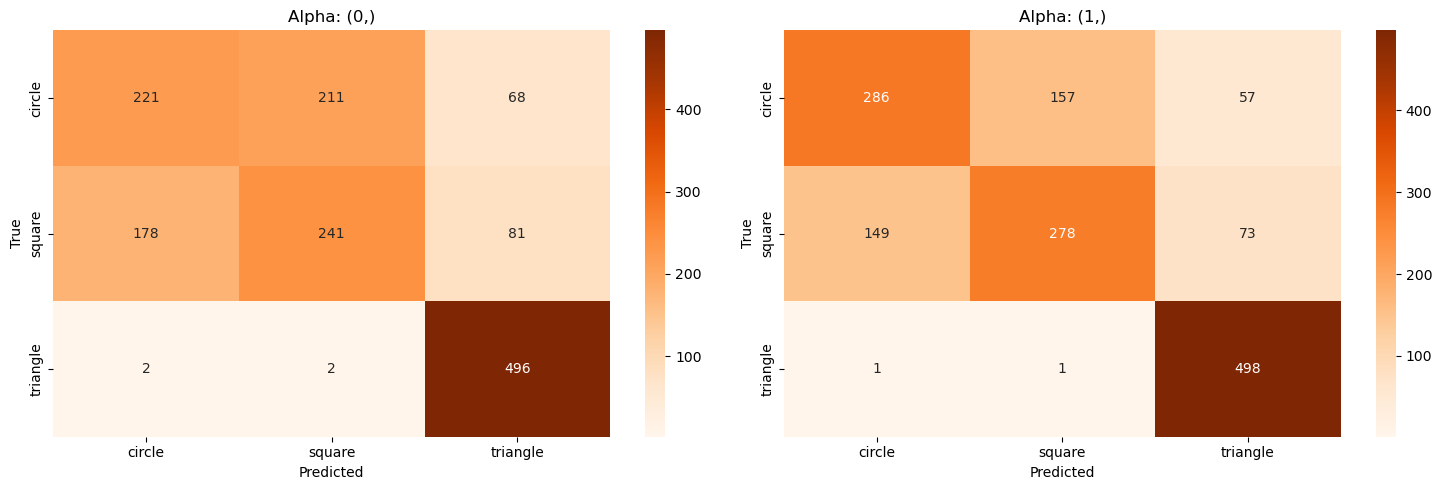

In [38]:
Classes_keys = ['circle', 'square','triangle']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes = axes.flatten()

for (idx, ((alpha), cm)) in enumerate(df.groupby(['alpha'])):
    ax = axes[idx]
    cm = confusion_matrix(cm['true_label'], cm['pred_label'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', ax=ax,
                xticklabels = Classes_keys,yticklabels = Classes_keys)
    ax.set_title(f'Alpha: {alpha}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.show()

We observe a slight improvement across all evaluation metrics. Naturally, further tunnig of the hyperparamters would be necessary to achieve optimal performace.